In [1]:
import numpy as np
from scipy import interpolate

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,8)
x=np.linspace(5.0,150.0,300)

In [3]:
#from confidence_ellipse import confidence_ellipse
from quadrature_error import quadrature_error_relative

<a id='top'></a>

# Executive Summary

This document shows a successful application of the rotameter calibration curves posted on the manufacturer's website. However, the use of more refined instruments to determine the flow of a gas mixture is necessary given the discrepancy between the measurement made from the individual components of the mixture and the calculations made on the basis of the rotometer in the gas mixture supply line as shown in the [summary plot](#theplot).

# Calibration

## Argon

[Table](https://www.mathesongas.com/pdfs/flowchart/602%20(E300)/ARGON%20602(E300)%20SS%200%20PSIG.pdf) at atmospheric pressure with stainless steel floater: $\phi_{\text{Ar}}(z)$

In [4]:
ro,cal=np.loadtxt('ARGON_602(E300)_SS_0_PSIG.dat',unpack=True) # sccm
arflowSS=interpolate.interp1d(ro, cal)

## Carbon Dioxide

[Table](https://www.mathesongas.com/pdfs/flowchart/602%20(E300)/CARBON%20DIOXIDE%20602(E300)%20GLASS%200%20PSIG.pdf) at atmospheric pressure with glass floater: $\phi_{\text{CO}_2}(z)$

In [5]:
ro,cal=np.loadtxt('CARBON_DIOXIDE_602(E300)_GLASS_0_PSIG.dat',unpack=True) # sccm
co2flowPY=interpolate.interp1d(ro, cal)

[Table](https://www.mathesongas.com/pdfs/flowchart/602%20(E300)/CARBON%20DIOXIDE%20602(E300)%20SS%200%20PSIG.pdf) at atmospheric pressure with stainless steel floater (used later).

In [6]:
ro,cal=np.loadtxt('CARBON_DIOXIDE_602(E300)_SS_0_PSIG.dat',unpack=True) # sccm
co2flowSS=interpolate.interp1d(ro, cal)

## Air

[Table](https://www.mathesongas.com/pdfs/flowchart/602%20(E300)/AIR%20602(E300)%20SS%200%20PSIG.pdf) at atmospheric pressure with stainless steel floater.


In [7]:
ro,cal=np.loadtxt('AIR_602(E300)_SS_0_PSIG.dat',unpack=True) # sccm
airflow=interpolate.interp1d(ro, cal)

## Plots

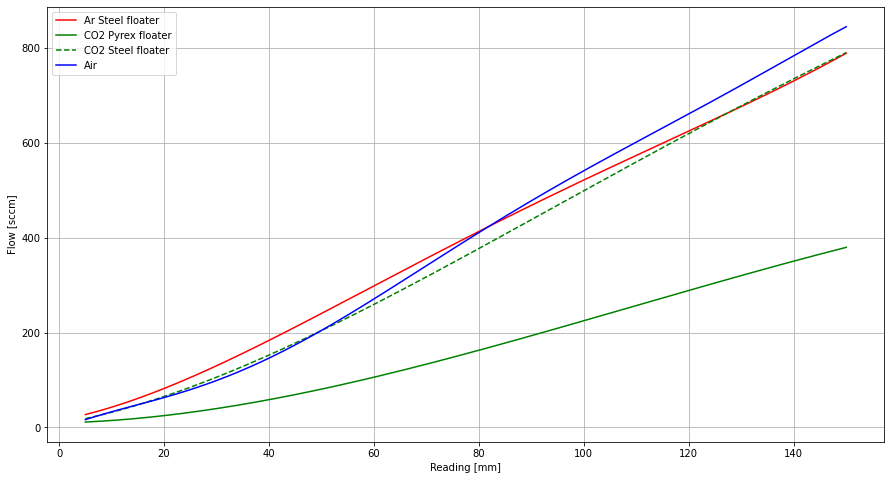

In [8]:
plt.plot(x, arflowSS(x), 'r', label='Ar Steel floater')
plt.plot(x, co2flowPY(x),'g', label='CO2 Pyrex floater')
plt.plot(x, co2flowSS(x),'g--', label='CO2 Steel floater')
plt.plot(x, airflow(x), 'b', label='Air')
plt.xlabel('Reading [mm]')
plt.ylabel('Flow [sccm]')
plt.grid()
plt.legend(loc='upper left')
plt.show()

# Determination of the flow prior to mixing

Carbon Dioxide flow $\phi_{\text{CO}_2}(z_1)$ for reading $z_1$

*pic goes here*

In [9]:
z1=85 # reading of glass floater
inCO2Flow=co2flowPY(z1)
print(f'CO2 inflow {inCO2Flow:.0f} sccm')

CO2 inflow 178 sccm


Argon flow $\phi_{\text{Ar}}(z_2)$ for reading $z_2$

*pic goes here*

In [10]:
z2=90 # reading of stainless stell floater
inArFlow=arflowSS(z2)
print(f'Ar inflow {inArFlow:.0f} sccm')

Ar inflow 469 sccm


Total flow prior to mixing $\phi_{\text{sum}}=\phi_{\text{CO}_2}(z_1)+\phi_{\text{Ar}}(z_2)$

In [11]:
totFlow=inCO2Flow+inArFlow
print(f'Total input Flow {totFlow:.0f} sccm')

Total input Flow 647 sccm


Calculate CO$_2$ fraction $\eta_{\text{CO}_2}=\tfrac{\phi_{\text{CO}_2}(z_1)}{\phi_{\text{sum}}}$

In [12]:
co2frac=inCO2Flow/totFlow
print(f'CO2 fraction {co2frac*100:.0f}%')

CO2 fraction 28%


## Error Estimation

[This](https://www.mathesongas.com/sites/default/files/inline-files/Model-FM-1050-High-Accuracy-Flowmeters.pdf) document reports that the accuracy of the tube is $\pm5\%$ of full scale flow rate.

The full scale rate for Argon using the calibration above is 790 sccm

In [13]:
Arerr=790.*0.05
print(f'Argon flow rate measurement accuracy: {Arerr:.1f}sccm')

Argon flow rate measurement accuracy: 39.5sccm


The full scale rate for Argon using the calibration above is 380 sccm

In [14]:
CO2err=380.*0.05
print(f'Carbon Dioxide flow rate measurement accuracy: {CO2err:.1f}sccm')

Carbon Dioxide flow rate measurement accuracy: 19.0sccm


Therefore the total flow rate is 

In [15]:
totErr=Arerr+CO2err
print(f'({totFlow:.0f} +/- {totErr:.0f}) sccm')

(647 +/- 58) sccm


The error for the Carbon Dioxide fraction is calcualted in quadrature

In [16]:
co2fracErr=co2frac*quadrature_error_relative(np.array([inCO2Flow,totFlow]),np.array([CO2err,totErr]))
print(f'CO2 fraction ({co2frac*100:.0f} +/- {co2fracErr*100:.0f})%')

CO2 fraction (28 +/- 4)%


# Determination of the flow of a gas mixture

## Calculate correction for different gas mixture - Version 1

There are few reasons to believe that this approach works correctly given [this](http://localhost:8888/notebooks/Documents/rotameter/CalibrationMixture_SS.ipynb) and [this](http://localhost:8888/notebooks/Documents/rotameter/CalibrationMixture_PY.ipynb). However, it's the method recommended by the manufacturer. 

According to [this](https://www.mathesongas.com/pdfs/flowchart/RotameterGasFactorChart.pdf) document, the recipe to determine the flow rate of a gas mixture $\phi_{\text{mix}}$ is to calculate the weighted average of the gas factors $f_i$ 
$$ F = \sum_i{ f_i \frac{v_i}{V_{\text{tot}}}} $$
and to multiply the calibration for air $\phi_{\text{air}}(z)$ by it
$$ \phi_{\text{mix}}(z) = F \phi_{\text{air}}(z) $$. 

In [17]:
Ar_factor=0.851
CO2_factor=0.808

The weights are given by the fractional volume of the mixture $\eta=\tfrac{v_i}{V_{\text{tot}}}$.

By indicating the mixture fraction by $\eta_{\text{Ar}}=1-\eta_{\text{CO}_2}$, $F$ is given by

In [18]:
mix_factor=((1.0-co2frac)*Ar_factor)+(co2frac*CO2_factor)
print(f'The mix factor is {mix_factor:.5f}')

The mix factor is 0.83916


## Calculate correction for different gas mixture - Version 2

There is another way to calcualte the flow rate of a gas mixture and is as follows
$$ \phi_{\text{mix}}(z) = \eta_{\text{Ar}} \phi_{\text{Ar}}(z) +  \eta_{\text{CO}_2} \phi_{\text{CO}_2}(z) $$

In [19]:
mixflow=interpolate.interp1d(x,(1.0-co2frac)*arflowSS(x)+co2frac*co2flowSS(x))

## Plots

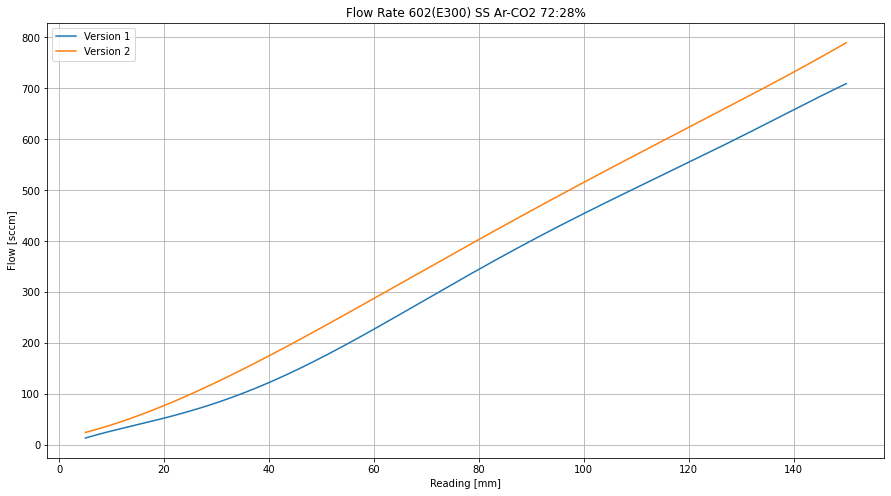

In [20]:
plt.plot(x, airflow(x)*mix_factor, label='Version 1')
plt.plot(x, mixflow(x), label='Version 2')
plt.xlabel('Reading [mm]')
plt.ylabel('Flow [sccm]')
plt.grid()
plt.title(f'Flow Rate 602(E300) SS Ar-CO2 {(1.-co2frac)*100:1.0f}:{co2frac*100:1.0f}%')
plt.legend(loc='upper left')
plt.show()

## Readout of the SS floater

*pic goes here*

In [21]:
inSS=105
outSS=55

Determine input flow post mixing with calculation "version 1"

In [22]:
inFlowV1=airflow(inSS)*mix_factor
print(f'Gas Mixture inflow {inFlowV1:.0f} sccm')

Gas Mixture inflow 480 sccm


Determine input flow post mixing with calculation "version 2"

In [23]:
inFlowV2=mixflow(inSS)
print(f'Gas Mixture inflow {inFlowV2:.0f} sccm')

Gas Mixture inflow 543 sccm


Determine output flow

In [24]:
outFlow=airflow(outSS)*mix_factor
print(f'Gas Mixture outflow {outFlow:.0f} sccm')

Gas Mixture outflow 199 sccm


Determine return fraction

In [25]:
print(f'Return fraction {outFlow/inFlowV1*100.0:.0f}%')

Return fraction 41%


## Error Estimation

The error on the "version 1" calcuation is obtained from the full scale rate for the gas mixture using the calibration above and is as follows:

In [26]:
mix_maxrate=airflow(150.)*mix_factor
print(f'Max flow rate for mixture {mix_maxrate:.0f} sccm')
mixerrV1=mix_maxrate*0.05

Max flow rate for mixture 709 sccm


The error on the "version 2" is determined in quadrature

In [27]:
CO2err=790.*0.05
temp1=(1.-co2frac)*arflowSS(inSS)*quadrature_error_relative(np.array([(1.-co2frac),arflowSS(inSS)]),
                                                            np.array([co2fracErr,Arerr]))
temp2=co2frac*co2flowSS(inSS)*quadrature_error_relative(np.array([co2frac,co2flowSS(inSS)]),
                                                        np.array([co2fracErr,CO2err]))
mixerrV2=temp1+temp2

Therefore the input and output flow rate of the mixture are

In [28]:
print(f'Input ver.1: ({inFlowV1:.0f} +/- {mixerrV1:.0f}) sccm')
print(f'Input ver.2: ({inFlowV2:.0f} +/- {mixerrV2:.0f}) sccm')
print(f'Output: ({outFlow:.0f} +/- {mixerrV1:.0f}) sccm')

Input ver.1: (480 +/- 35) sccm
Input ver.2: (543 +/- 59) sccm
Output: (199 +/- 35) sccm


## Plot

Put everything together
<a id='theplot'></a>

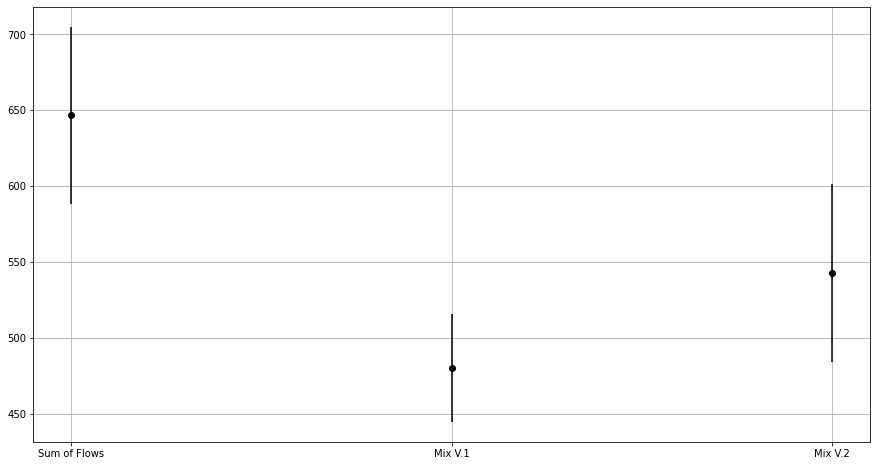

In [29]:
n=range(3)
plt.errorbar(n, [totFlow,inFlowV1,inFlowV2], yerr=[totErr,mixerrV1,mixerrV2], label='', fmt='ok')
plt.xticks(n, ('Sum of Flows','Mix V.1','Mix V.2'))
_,ymax=plt.ylim()
#plt.ylim(0.,ymax)
plt.grid()
plt.show()

[Top of the page](#top)